# Snapping points to closest 
- As a test, I will use data from Sidewalk Café Licenses and Applications from NYC Open Data portal
- https://data.cityofnewyork.us/Business/Sidewalk-Caf-Licenses-and-Applications/qcdj-rwhu
- For the line network, I will use NYC's Lion street data
- https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-lion.page

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import box, LineString, Point,MultiPoint
import os
import sys
import requests
from zipfile import ZipFile as zzip
import fiona
from scipy.spatial import cKDTree
import numpy as np

sys.path.append(os.path.realpath('..'))

Get the Sidewalk Café Licenses and Applications data!

In [9]:
fp = r"https://data.cityofnewyork.us/api/views/qcdj-rwhu/rows.csv?accessType=DOWNLOAD"
sidewalk_df = pd.read_csv(fp)

In [12]:
sidewalk_df.columns

Index(['LICENSE_NBR', 'LIC_STATUS', 'BUSINESS_NAME', 'BUSINESS_NAME2',
       'BUILDING', 'STREET', 'CITY', 'STATE', 'ZIP', 'SWC_TYPE', 'SWC_SQ_FT',
       'SWC_TABLES', 'SWC_CHAIRS', 'DOHMH', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_DISTRICT', 'CITY_COUNCIL_DISTRICT', 'CD_URL', 'APP_ID',
       'APP_SWC_TYPE', 'APP_SQ_FT', 'APP_TABLES', 'APP_CHAIRS', 'APP_STATUS',
       'APP_STATUS_DATE', 'EXPIRATION_DATE', 'APP_TOO_DATE', 'SUBMIT_DATE',
       'INTAKE', 'INTAKE_DD', 'DPQA', 'SEND_PACKAGE_DD', 'CP', 'CP_DD', 'CB',
       'CB_DD', 'HEARING', 'HEARING_DD', 'HEARING_PUBLIC', 'HEARING_PUBLIC_DD',
       'CC', 'CC_DD', 'MOO', 'MOO_DD', 'ISSUANCE', 'ISSUANCE_DD'],
      dtype='object')

In [15]:
sidewalk_df['geometry'] =  list(zip(sidewalk_df['LONGITUDE'], sidewalk_df['LATITUDE']))

In [16]:
sidewalk_df['geometry'] = sidewalk_df['geometry'].apply(Point)

In [17]:
sidewalk_gdf = gpd.GeoDataFrame(sidewalk_df, geometry='geometry')

In [18]:
sidewalk_gdf.crs = {'init': 'epsg:4326'}

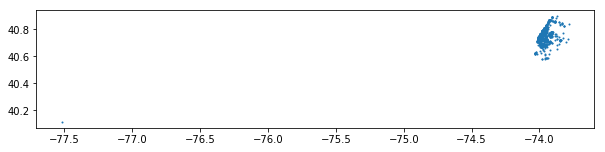

In [19]:
sidewalk_gdf.plot(figsize = (10,10), markersize = 1)

In [23]:
sidewalk_gdf['LICENSE_NBR'].count()

1421

In [24]:
sidewalk_gdf = sidewalk_gdf[sidewalk_gdf['LONGITUDE']>-74.5 ]

In [25]:
sidewalk_gdf['LICENSE_NBR'].count()

1420

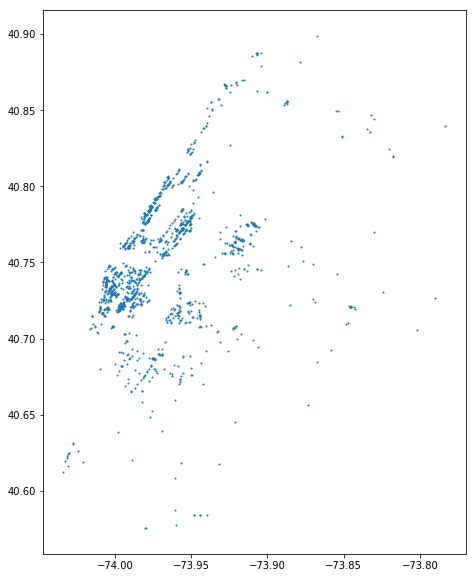

In [26]:
sidewalk_gdf.plot(figsize = (10,10), markersize = 1)

## Read in the lion file
- We will use the `clean_lion_line` shapefile we had created in the network_distance_lion.ipynb

In [28]:
fp = r"../intermediate_data/clean_lion_line.shp"
clean_lion_gdf = gpd.read_file(fp)

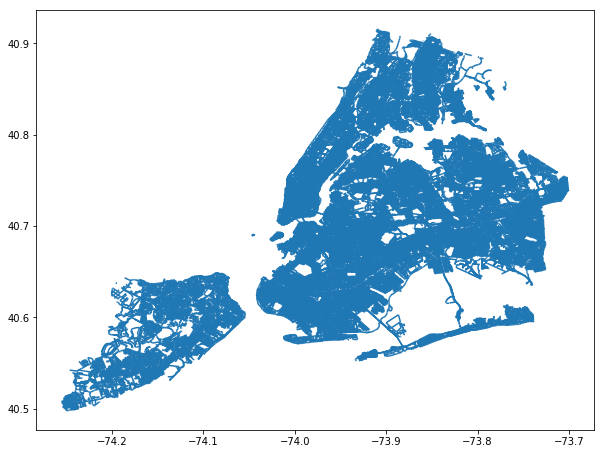

In [29]:
clean_lion_gdf.plot(figsize = (10,10))

We turn the lines into a single geometry using `unary_union` function

In [30]:
union_clean_lion_gdf = clean_lion_gdf.geometry.unary_union

## Linear referencing
I followed the method outlined here to snap the locations to the nearest pedestrian accessible street. 

Source: https://gis.stackexchange.com/questions/306838/snap-points-shapefile-to-line-shapefile-using-shapely

In [34]:
sidewalk_gdf['geometry_st'] = result.apply(lambda row: union_clean_lion_gdf.interpolate(union_clean_lion_gdf.project(row.geometry)), axis=1)

In [35]:
sidewalk_gdf.head()

LICENSE_NBR LIC_STATUS                        BUSINESS_NAME BUSINESS_NAME2  \
0  1440433-DCA     Active                  MS RESTAURANT CORP.        AGNANTI   
1  1315977-DCA     Active  RECTOR STREET FOOD ENTERPRISES LTD.            NaN   
2  0918358-DCA     Active                  RESTAURANT 597 INC.       BUS STOP   
3  2035045-DCA     Active                CHEZ AMIS CORPORATION       FLAT TOP   
4  1167909-DCA     Active                         THIERRY INC.            NaN   

  BUILDING           STREET      CITY STATE    ZIP          SWC_TYPE  ...  \
0     1906     DITMARS BLVD   ASTORIA    NY  11105          Enclosed  ...   
1    87-89  GREENWICH STEET  NEW YORK    NY  10006        Unenclosed  ...   
2      597        HUDSON ST  NEW YORK    NY  10014        Unenclosed  ...   
3     1241    AMSTERDAM AVE  NEW YORK    NY  10027        Unenclosed  ...   
4       19        E 69TH ST  NEW YORK    NY  10021  Small Unenclosed  ...   

   HEARING_PUBLIC  HEARING_PUBLIC_DD                     CC       CC_DD  \
0             NaN                NaN         Pending Review         NaN   
1             NaN                NaN  Review Period Expired  05/15/2019   
2             NaN                NaN  Review Period Expired  02/14/2019   
3             NaN                NaN  Review Period Expired  06/29/2018   
4             NaN                NaN  Review Period Expired  11/22/2018   

              MOO      MOO_DD        ISSUANCE  ISSUANCE_DD  \
0  Pending Review         NaN          Issued   05/30/2018   
1  Pending Review         NaN  Pending Review          NaN   
2        Approved  04/02/2019          Issued   04/02/2019   
3             NaN         NaN          Issued   10/26/2018   
4        Approved  02/11/2019          Issued   02/11/2019   

                                       geometry  \
0  POINT (-73.91784619579741 40.78098390044382)   
1   POINT (-74.0135041628193 40.70793068772063)   
2  POINT (-74.00595756048909 40.73702027286546)   
3   POINT (-73.9584969980864 40.80999005073067)   
4  POINT (-73.96657644959133 40.76984548940728)   

                                    geometry_st  
0   POINT (-73.91776638059547 40.7808873180202)  
1  POINT (-74.01350153791512 40.70793908949759)  
2  POINT (-74.00596176863441 40.73693181531322)  
3  POINT (-73.95852266141725 40.80992764808176)  
4  POINT (-73.96661671935232 40.76974975869061)  

[5 rows x 49 columns]